Делаем генеративно-состязательную сеть в Keras и Tensorflow | #32 нейросети на Python


In [2]:


import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[y_train == 7]
y_train = y_train[y_train == 7]

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

BUFFER_SIZE = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:BUFFER_SIZE]
y_train = y_train[:BUFFER_SIZE]
print(x_train.shape, y_train.shape)


(6200, 28, 28) (6200,)


In [4]:
# стандартизация входных данных
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


2025-01-05 17:15:58.436642: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-01-05 17:15:58.436664: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-01-05 17:15:58.436669: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-01-05 17:15:58.436841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-05 17:15:58.436854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
hidden_dim = 2


def dropout_and_batch():
  return Dropout(0.3)(BatchNormalization())


# генератор
generator = tf.keras.Sequential([
  Dense(7 * 7 * 256, activation='relu', input_shape=(hidden_dim,)),
  BatchNormalization(),
  Reshape((7, 7, 256)),
  Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='relu'),
  BatchNormalization(),
  Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='sigmoid'),
])


In [13]:
# дискриминатор
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))

# потери
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def generator_loss(fake_output):
  loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return loss


def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
# обучение
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, hidden_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [16]:
def train(dataset, epochs):
  history = []
  MAX_PRINT_LABEL = 10
  th = BUFFER_SIZE // (BATCH_SIZE * MAX_PRINT_LABEL)

  for epoch in range(1, epochs + 1):
    print(f'{epoch}/{EPOCHS}: ', end='')

    start = time.time()
    n = 0

    gen_loss_epoch = 0
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_epoch += K.mean(gen_loss)
      if (n % th == 0): print('=', end='')
      n += 1

    history += [gen_loss_epoch / n]
    print(': ' + str(history[-1]))
    print('Время эпохи {} составляет {} секунд'.format(epoch, time.time() - start))

  return history


1/20: ===========: tf.Tensor(1.4919783, shape=(), dtype=float32)
Время эпохи 1 составляет 4.879447937011719 секунд
2/20: =

2025-01-05 17:18:48.438325: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(2.6032033, shape=(), dtype=float32)
Время эпохи 2 составляет 3.1128389835357666 секунд
3/20: =

2025-01-05 17:18:51.550678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(3.2393177, shape=(), dtype=float32)
Время эпохи 3 составляет 3.0276031494140625 секунд
4/20: =

2025-01-05 17:18:54.579262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(3.414685, shape=(), dtype=float32)
Время эпохи 4 составляет 3.2321550846099854 секунд
5/20: =

2025-01-05 17:18:57.815271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(3.4450934, shape=(), dtype=float32)
Время эпохи 5 составляет 3.1167430877685547 секунд
6/20: =

2025-01-05 17:19:00.927139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(3.1240458, shape=(), dtype=float32)
Время эпохи 6 составляет 3.0101940631866455 секунд
7/20: =

2025-01-05 17:19:03.937678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(2.8546314, shape=(), dtype=float32)
Время эпохи 7 составляет 3.0147268772125244 секунд
8/20: =

2025-01-05 17:19:06.953018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(3.2423072, shape=(), dtype=float32)
Время эпохи 8 составляет 3.043145179748535 секунд
9/20: =

2025-01-05 17:19:09.998908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(3.437146, shape=(), dtype=float32)
Время эпохи 9 составляет 3.0891709327697754 секунд
10/20: =

2025-01-05 17:19:13.087759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(1.9267226, shape=(), dtype=float32)
Время эпохи 10 составляет 3.1041221618652344 секунд
11/20: =

2025-01-05 17:19:16.191473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(1.2448488, shape=(), dtype=float32)
Время эпохи 11 составляет 3.1381211280822754 секунд
12/20: =

2025-01-05 17:19:19.333294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(1.1848722, shape=(), dtype=float32)
Время эпохи 12 составляет 3.1830971240997314 секунд
13/20: =

2025-01-05 17:19:22.519686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(1.1473238, shape=(), dtype=float32)
Время эпохи 13 составляет 3.202148914337158 секунд
14/20: =

2025-01-05 17:19:25.718747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(1.1725603, shape=(), dtype=float32)
Время эпохи 14 составляет 3.278416872024536 секунд
15/20: =

2025-01-05 17:19:28.996267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(1.1482036, shape=(), dtype=float32)
Время эпохи 15 составляет 3.2855327129364014 секунд
16/20: =

2025-01-05 17:19:32.284210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(1.1032512, shape=(), dtype=float32)
Время эпохи 16 составляет 3.6757562160491943 секунд
17/20: =

2025-01-05 17:19:35.963371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(1.1453011, shape=(), dtype=float32)
Время эпохи 17 составляет 3.715657949447632 секунд
18/20: =

2025-01-05 17:19:39.682455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(1.098809, shape=(), dtype=float32)
Время эпохи 18 составляет 3.655660629272461 секунд
19/20: =

2025-01-05 17:19:43.334742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(1.0238158, shape=(), dtype=float32)
Время эпохи 19 составляет 3.472543954849243 секунд
20/20: =

2025-01-05 17:19:46.806660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


==========: tf.Tensor(0.99078393, shape=(), dtype=float32)
Время эпохи 20 составляет 3.4827661514282227 секунд


2025-01-05 17:19:50.289756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


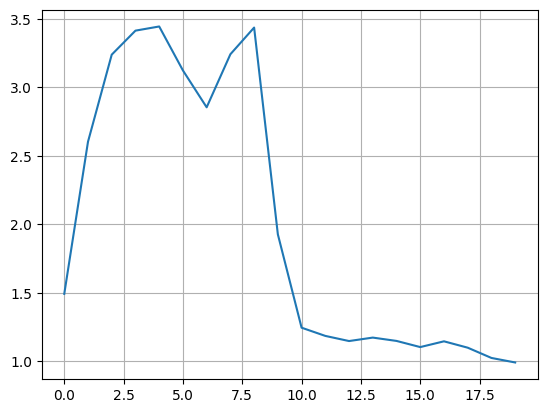

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [17]:
# запуск процесса обучения
EPOCHS = 20
history = train(train_dataset, EPOCHS)

plt.plot(history)
plt.grid(True)
plt.show()

# отображение результатов генерации
n = 2
total = 2 * n + 1

plt.figure(figsize=(total, total))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


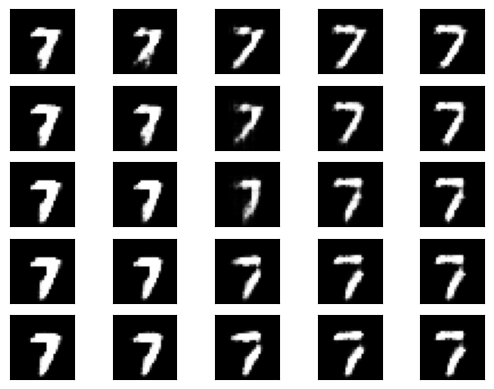

In [18]:
num = 1
for i in range(-n, n + 1):
  for j in range(-n, n + 1):
    ax = plt.subplot(total, total, num)
    num += 1
    img = generator.predict(np.expand_dims([0.5 * i / n, 0.5 * j / n], axis=0))
    plt.imshow(img[0, :, :, 0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
# сохранение модели